In [180]:
#requires tensorflow2
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import keras
import numpy as np
from ads_utils import load_data, plot, Environment

In [181]:
INITIAL_BALANCE = 10_000
PAST_TICKS = 5
        
'''NOTE: there is no train/test split yet'''            
data = load_data([2])

fake = np.linspace(100, 200, len(data))
data['close1'] = fake
fake = np.linspace(200, 100, len(data))
data['close2'] = fake
fake = 10*np.sin(np.linspace(0, 3141.592, len(data))/50) + 20
data['close3'] = fake
fake = 100*np.sin(np.linspace(0, 3141.592, len(data))/50) + np.random.normal(1000, 50, len(data))
data['close4'] = fake
fake = np.random.normal(1000, 50, len(data))
data['close5'] = fake
fake = 1000 - np.abs(np.arange(0, len(data)) - len(data)/2) * 0.05
data['close6'] = fake
fake = np.random.normal(1000, 50, len(data)) - np.abs(np.arange(0, len(data)) - len(data)/2) * 0.05
data['close7'] = fake

envs = []
for col in ['close'] + [f'close{i}' for i in range(1, 8)]:
    env = Environment(data[col].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
    envs.append(env)

In [195]:
dataset = np.reshape(data['close'].values,(-1,1))

In [196]:
scaled_dataset = dataset

In [197]:
train= scaled_dataset[:int(scaled_dataset.shape[0]*0.8)]
valid = scaled_dataset[int(scaled_dataset.shape[0]*0.8)-60:]

In [200]:
#if feature scaling desired
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))


In [201]:
train2 = sc.fit_transform(train)

In [203]:
valid2 = sc.transform(valid)

In [205]:
x_train,y_train,x_test,y_test = [],[],[],[]
for i in range(60,train2.shape[0]):
    x_train.append(train2[i-60:i,0])
    y_train.append(train2[i,0])

for z in range(60,valid2.shape[0]):
    x_test.append(valid2[z-60:z,0])
    y_test.append(valid2[z,0])

In [206]:
x_train, y_train,x_test,y_test = np.array(x_train), np.array(y_train),np.array(x_test),np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

Epoch 1/50
105/105 [==============================] - 10s 99ms/step - loss: 0.0050 - val_loss: 0.0224
Epoch 2/50
105/105 [==============================] - 9s 85ms/step - loss: 0.0071 - val_loss: 0.0155
Epoch 3/50
105/105 [==============================] - 12s 112ms/step - loss: 0.0054 - val_loss: 0.0100
Epoch 4/50
105/105 [==============================] - 10s 98ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 5/50
105/105 [==============================] - 14s 136ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 6/50
105/105 [==============================] - 13s 120ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 7/50
105/105 [==============================] - 11s 104ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 8/50
105/105 [==============================] - 11s 105ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/50
105/105 [==============================] - 9s 87ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 10/50
105/105 [==============================] - 9s 83ms/step - loss: 0.0

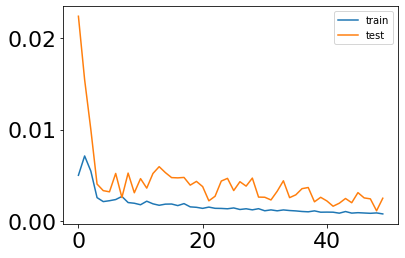

In [207]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
from keras.optimizers import Adam
model = Sequential()
model.add(LSTM(units=100,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=100))
model.add(Dropout(0.4))
model.add(Dense(1))
ADAM = Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=ADAM)
history = model.fit(x_train,y_train,epochs=50,batch_size=72,validation_data=(x_test,y_test),verbose=1,shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [208]:
predicted_stock_price = sc.inverse_transform(model.predict(x_test))

In [211]:
actual_stock_price = sc.inverse_transform(y_test.reshape((-1,1)))

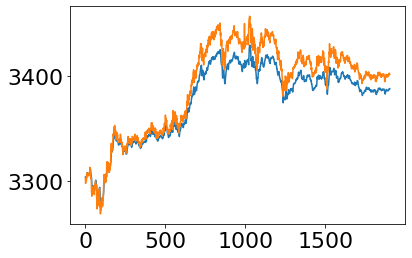

In [214]:
plt.plot(predicted_stock_price)
plt.plot(actual_stock_price)
plt.show()

In [215]:
#computing profitability

In [217]:
balance = INITIAL_BALANCE
for i in range(1,len(predicted_stock_price)):
    if predicted_stock_price[i]>actual_stock_price[i-1]:
        #go long
        balance += actual_stock_price[i]-actual_stock_price[i-1]
    else:
        #go short
        balance += actual_stock_price[i-1]-actual_stock_price[i]

In [218]:
balance

array([9964.382])